In [ ]:
#|default_exp sadspheres
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *
# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm

## project specifics'
import diffusion_curvature

from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
# from diffusion_curvature.core import *
from diffusion_curvature.utils import *
# from diffusion_curvature.comparison_space import *

%load_ext autoreload
%autoreload 2

# Saddle Sphere Ablations
> Little brother to the Curvature Colosseum

This is a dataset intended to measure the sign discrimination ability of diffusion curvature and other curvature methods. The dataset consists of different samplings of saddles and spheres with varying intensities of curvature and in varying dimensions. There's also the possibility of adding noise. This notebook implements a class which creates this dataset with specified parameters as well as convenience functions which can be used for testing it and visualizing the results.

# Implementation

Because of the specialized purpose of this dataset, we're wrapping it in a special class, which allows the dataset to evaluate its own fidelity in embeddings.

It works like this:
1. Instatiate the class, supply the dimensions, and noise level, and it will create all of the graphs.
2. To run curvature computations on these graphs, you can extract them directly -- or, you can use the dataset as an *iterator*, loop through, run your own logic within, then run an 'update' function to store the result.
3. Afterwards, you can use the built in methods for visualizing and getting metrics on the performance.

In [ ]:
#|export
from diffusion_curvature.core import get_adaptive_graph
from diffusion_curvature.datasets import rejection_sample_from_saddle, sphere, plane
from fastcore.all import *
import xarray as xr
import inspect
import pandas as pd

import sklearn
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

def metric(func):
    setattr(func, 'tag', 'metric')
    return func

class SadSpheres():
    def __init__(self,
                 dimension = 2, # Dimension of saddles and spheres
                 num_pointclouds = 100, # num pointclouds to make in total
                 num_points = 2000, # num points per pointclouds
                 noise_level = 0, # from 0 to 1. 1 is all noise.
                 include_planes = False, # if True, includes randomly sampled planes as a sanity check.
                ):
        store_attr()
        self.DS = xr.Dataset()
        self.idx = -1
        self.dnum = 3 if self.include_planes else 2
        for i in range(num_pointclouds//self.dnum):
            X_saddle, ks_saddle = rejection_sample_from_saddle(self.num_points, self.dimension)
            self.DS[self.dnum*i] = xr.DataArray(X_saddle, dims=['n', 'd'], attrs={'ks':ks_saddle, 'name':'Saddle'})
            X_sphere, ks_sphere = sphere(self.num_points, self.dimension)
            self.DS[self.dnum*i+1] = xr.DataArray(X_sphere, dims=['n', 'd'], attrs={'ks':ks_sphere[0], 'name':'Sphere'})
            if self.include_planes:
                X_plane = plane(self.num_points, self.dimension) 
                X_plane = np.hstack([X_plane, np.zeros(self.num_points)[:,None]])
                self.DS[self.dnum*i + 2] = xr.DataArray(X_plane, dims=['n', 'd'], attrs = {'ks':0, 'name':'Plane'})
    
    def __iter__(self):
        return self

    def __len__(self):
        return len(self.DS)

    def __next__(self):
        self.idx += 1
        if self.idx >= self.__len__():
            raise StopIteration
        result = self.DS[self.idx].to_numpy()
        return result

    def update(self,
               result,
               method_name='computed'):
        """
        Store the result of the curvature computation by passing the computed curvature of the center (first) point.
        """
        self.DS[self.idx].attrs[method_name] = result

    def compute_metrics(self):
        self._aggregate_labels()
        metrics = self._get_metrics()
        self.metric_table = {}
        for metric in metrics:
            self.metric_table[metric.__name__] = {}
            for method_name in self.method_names:
                self.metric_table[metric.__name__][method_name] = self.compute(metric=metric, method_name=method_name)
        self.metric_table = pd.DataFrame(self.metric_table)
            
    def compute(self, metric, method_name):
        # Overwrite this class with your logic. It implements the computation of a single metric for a single method
        return metric(self.labels[method_name], self.labels['ks'])
    

    def _aggregate_labels(self):
        self.method_names = list(self.DS.data_vars[0].attrs.keys())
        self.method_names.remove('name')
        self.labels = {}
        for m in self.method_names:
            self.labels[m] = np.array([self.DS.data_vars[i].attrs[m] for i in range(self.__len__())])

    def plot(self, title = None):
        if title is None: title = f"In dimension {self.dimension}"
        # for each computed method on this dataset, we plot the histogram of saddles vs spheres
        self._aggregate_labels()
        # get the idxs for each type of dataset
        dataset_names = [self.DS.data_vars[i].attrs['name'] for i in range(len(self.DS))]
        unique_names = list(set(dataset_names))
        idxs_by_name = {n: [i for i, name in enumerate(dataset_names) if name == n] for n in unique_names}        
        for m in self.method_names: 
            if m != 'ks' and m != 'name':
                for dname in unique_names:
                    plt.hist(self.labels[m][idxs_by_name[dname]], bins=50, label = dname, edgecolor='none', linewidth=5)
                plt.legend()
                plt.xlabel(m)
                plt.title(title)
                plt.show()

    def table(self):
        self.compute_metrics()
        return self.metric_table

    def _get_metrics(self):
        tagged_functions = []
        for name, member in inspect.getmembers(self, predicate=inspect.ismethod):
            if hasattr(member, 'tag') and getattr(member, 'tag') == 'metric':
                tagged_functions.append(member)
        return tagged_functions

    @metric
    def pearson_r(self, a, b):
        return scipy.stats.pearsonr(a,b)

    @metric
    def sign_score(self, a, b):
        # measures the extent to which the sign of a agrees with b
        return sklearn.metrics.mutual_info_score(
            np.sign(a),
            np.sign(b),
        )
        
    

# Tests

In [ ]:
from diffusion_curvature.core import *

In [ ]:
SS = SadSpheres(
    dimension = 2, # Dimension of saddles and spheres
    num_pointclouds = 100, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes=True,
)
graph_former = partial(get_adaptive_graph,k=5,alpha=1)
for X in tqdm(SS):
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Entropic",
        flattening_method="Fixed",
        comparison_method="Subtraction",
        graph_former = graph_former,
        points_per_cluster=None, # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, dim = 2, t = 25)
    SS.update(ks[0], method_name="Diffusion Entropic Curvature")
    DC = DiffusionCurvature(
        laziness_method="Wasserstein",
        flattening_method="Fixed",
        comparison_method="Ollivier",
        graph_former = graph_former,
        points_per_cluster=None, # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, dim = 2, t = 25)
    SS.update(ks[0], method_name="Diffusion Wasserstein Curvature")

  0%|          | 0/99 [00:00<?, ?it/s]

updating with k -0.17392253875732422 for Saddle
updating with k 0.20943737030029297 for Sphere
updating with k -0.05047035217285156 for Plane
updating with k -0.1786203384399414 for Saddle
updating with k 0.09102487564086914 for Sphere
updating with k 0.09760332107543945 for Plane
updating with k -0.06014108657836914 for Saddle
updating with k 0.03847980499267578 for Sphere
updating with k 0.03792238235473633 for Plane
updating with k -0.1468038558959961 for Saddle
updating with k 0.013775825500488281 for Sphere
updating with k -0.11577463150024414 for Plane
updating with k -0.014618873596191406 for Saddle
updating with k 0.09740781784057617 for Sphere
updating with k 0.10169219970703125 for Plane
updating with k 0.023841381072998047 for Saddle
updating with k 0.02372455596923828 for Sphere
updating with k 0.02215719223022461 for Plane
updating with k -0.08730220794677734 for Saddle
updating with k 0.0708465576171875 for Sphere
updating with k -0.020064830780029297 for Plane
updating w

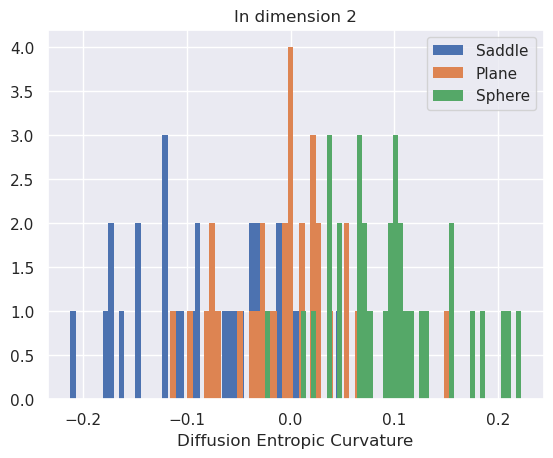

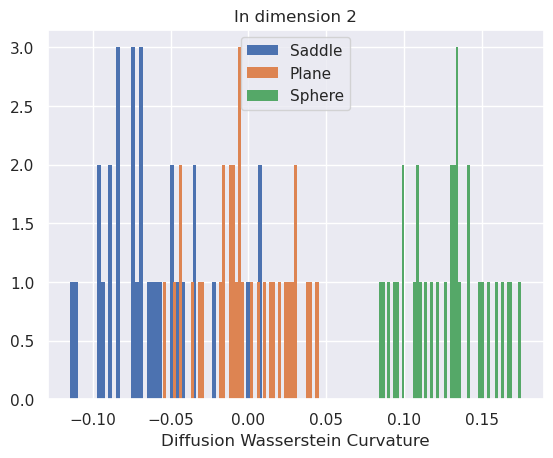

In [ ]:
# globally
SS.plot()

In [ ]:
SS.table()

,pearson_r,sign_score
ks,"(1.0, 0.0)",1.098612
Diffusion Entropic Curvature,"(0.6898919312953438, 2.841124913132981e-15)",0.292600
Diffusion Wasserstein Curvature,"(0.8061863975083174, 7.758684127862867e-24)",0.364343


In [ ]:
# sync changes to the library
from IPython.display import display, Javascript
import time
display(Javascript('IPython.notebook.save_checkpoint();'))
time.sleep(2)
!pixi run nbsync

<IPython.core.display.Javascript object>

 WARN pixi::project::manifest: BETA feature `[pypi-dependencies]` enabled!

Please report any and all issues here:

	https://github.com/prefix-dev/pixi.

Turn this warning off by setting the environment variable `PIXI_BETA_WARNING_OFF` to `true`.

✨ Pixi task (default): nbdev_export
⠁ activating environment                                                                 